<a href="https://colab.research.google.com/github/Nag-Nad/Machine-Learning-in-Chemistry/blob/main/TEST1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install rdkit

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import PandasTools

import glob
import pandas as pd
import seaborn as sns
import matplotlib

In [ ]:
# Concatenate csv files into one dataframe using glob library

csv_files = glob.glob('/content/drive/MyDrive/Colab Notebooks/Test1/**/*.csv', recursive=True)
data = pd.DataFrame()
data = pd.concat([pd.read_csv(files) for files in csv_files], ignore_index = True)
data

,zinc_id,smiles
0,ZINC000000001084,Cn1c(=O)c2c(ncn2C)n(C)c1=O
1,ZINC000000033882,NCCc1ccc(O)c(O)c1
2,ZINC000000001411,C=CCc1ccc(O)c(OC)c1
3,ZINC000001482164,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1O
4,ZINC000001532517,CC(=O)C(=O)O


In [ ]:
# Add a new column to the dataframe at the location 0
molecules = ['Ice', 'Dopamine', 'Eugenol', 'Caffeine', 'Pyruvate']
data.insert(0, 'Molecules', molecules)
data

,Molecules,zinc_id,smiles
0,Ice,ZINC000000001084,Cn1c(=O)c2c(ncn2C)n(C)c1=O
1,Dopamine,ZINC000000033882,NCCc1ccc(O)c(O)c1
2,Eugenol,ZINC000000001411,C=CCc1ccc(O)c(OC)c1
3,Caffeine,ZINC000001482164,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1O
4,Pyruvate,ZINC000001532517,CC(=O)C(=O)O


In [ ]:
# Calculate the Molecular Weight
data['MolWt'] = data['smiles'].apply(lambda smiles: Chem.Descriptors.MolWt(Chem.MolFromSmiles(smiles))
if Chem.MolFromSmiles(smiles) else None)

# Calculate the number of heavy atoms
data['HeavyAtoms_number'] = data['smiles'].apply(lambda smiles: Chem.Descriptors.HeavyAtomCount(Chem.MolFromSmiles(smiles))
if Chem.MolFromSmiles(smiles) else None)

# Calculate the number of rotatable bonds
data['Rotatable_bonds'] = data['smiles'].apply(lambda smiles: Chem.Descriptors.NumRotatableBonds(Chem.MolFromSmiles(smiles))
if Chem.MolFromSmiles(smiles) else None)

# Calculate logP
data['logP'] = data['smiles'].apply(lambda smiles: Chem.Descriptors.MolLogP(Chem.MolFromSmiles(smiles))
if Chem.MolFromSmiles(smiles) else None)

data

,Molecules,zinc_id,smiles,MolWt,HeavyAtoms_number,Rotatable_bonds,logP
0,Ice,ZINC000000001084,Cn1c(=O)c2c(ncn2C)n(C)c1=O,194.194,14,0,-1.0293
1,Dopamine,ZINC000000033882,NCCc1ccc(O)c(O)c1,153.181,11,2,0.5990
2,Eugenol,ZINC000000001411,C=CCc1ccc(O)c(OC)c1,164.204,12,3,2.1293
3,Caffeine,ZINC000001482164,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1O,156.269,11,1,2.4395
4,Pyruvate,ZINC000001532517,CC(=O)C(=O)O,88.062,6,1,-0.3400


In [ ]:
# Apply the conditions:
'''
1. the molecular weight of molecules must be between 100-700 Da;
2. total number of atoms of each molecule must be less than or equal to 60;
3. number of rotatable bonds must be less than or equal to 15;
4. octonal-water coefficient (logP) must be less than or equal to 5.
'''

mdata = data.loc[(data['MolWt']<700) & (data['MolWt'] > 100) &
 (data['HeavyAtoms_number'] <= 60) & (data['Rotatable_bonds'] <= 15) &
  (data['logP'] <= 5)]

mdata

,Molecules,zinc_id,smiles,MolWt,HeavyAtoms_number,Rotatable_bonds,logP
0,Ice,ZINC000000001084,Cn1c(=O)c2c(ncn2C)n(C)c1=O,194.194,14,0,-1.0293
1,Dopamine,ZINC000000033882,NCCc1ccc(O)c(O)c1,153.181,11,2,0.5990
2,Eugenol,ZINC000000001411,C=CCc1ccc(O)c(OC)c1,164.204,12,3,2.1293
3,Caffeine,ZINC000001482164,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1O,156.269,11,1,2.4395


In [ ]:
# Convert SMILES to molecule objects
mol_list = []
for smiles in mdata['smiles']:
    mol = Chem.MolFromSmiles(smiles)
    mol_list.append(mol)

def calculate_Morgan_fingerprint (mol):
  Morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048)
  return Morgan_fp



def calculate_tanimoto_coefficient(fp1, fp2):
    tanimoto = DataStructs.TanimotoSimilarity(fp1, fp2)
    return tanimoto


# Create a similarity matrix DataFrame
similarity_matrix = pd.DataFrame(index=mdata['Molecules'], columns=mdata['Molecules'])

# Calculate Tanimoto similarity for each pair of molecules
for i in range(len(mol_list)):
    for j in range(i, len(mol_list)):
        mol1 = mol_list[i]
        mol2 = mol_list[j]
        fp1 = calculate_Morgan_fingerprint (mol1)
        fp2 = calculate_Morgan_fingerprint (mol2)
        tanimoto_coefficient = calculate_tanimoto_coefficient(fp1, fp2)
        similarity_matrix.iat[i, j] = tanimoto_coefficient
        similarity_matrix.iat[j, i] = tanimoto_coefficient

similarity_matrix = similarity_matrix.fillna(1.0)  # Fill None Values with 1.0


similarity_matrix


Molecules,Ice,Dopamine,Eugenol,Caffeine
Molecules,,,,
Ice,1.000000,0.033898,0.045455,0.016949
Dopamine,0.033898,1.000000,0.240000,0.039216
Eugenol,0.045455,0.240000,1.000000,0.051724
Caffeine,0.016949,0.039216,0.051724,1.000000


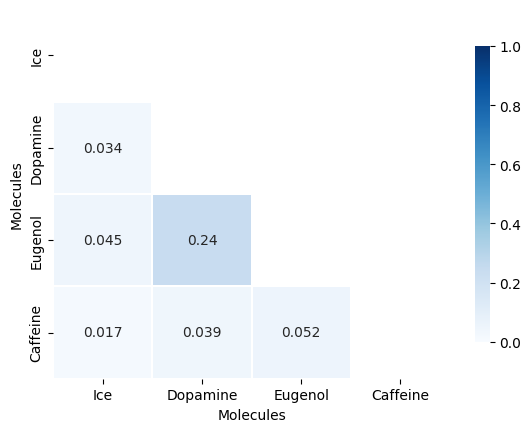

In [ ]:
from numpy.lib.twodim_base import mask_indices
import numpy as np

#matrix = similarity_matrix.corr()
#matrix
mask = np.zeros_like(similarity_matrix)
mask[np.triu_indices_from(mask)]=True
heatmap = sns.heatmap(similarity_matrix, annot=True, cmap="Blues", vmin= 0.0, vmax=1.0,
           linewidth=0.3, cbar_kws={"shrink": .8}, mask = mask)

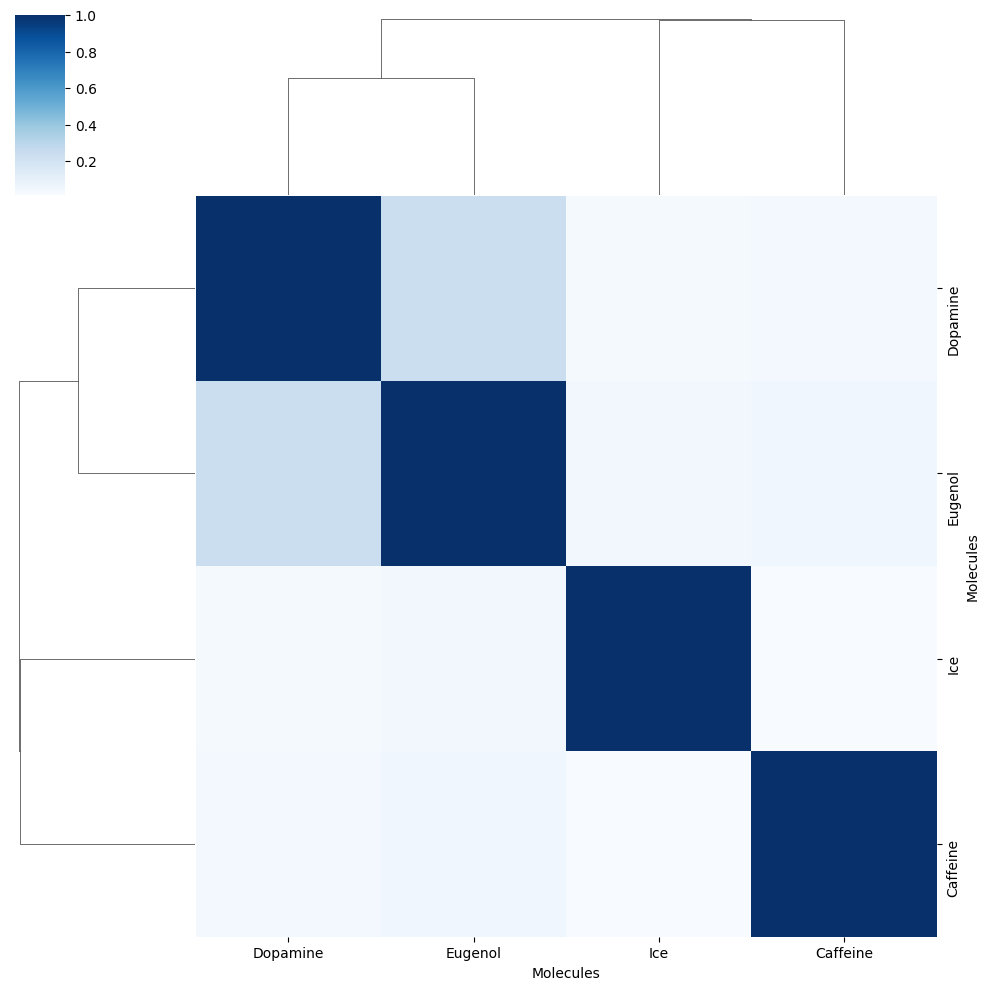

In [ ]:

from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt


sns.clustermap(similarity_matrix, cmap='Blues', metric="correlation", method="single")


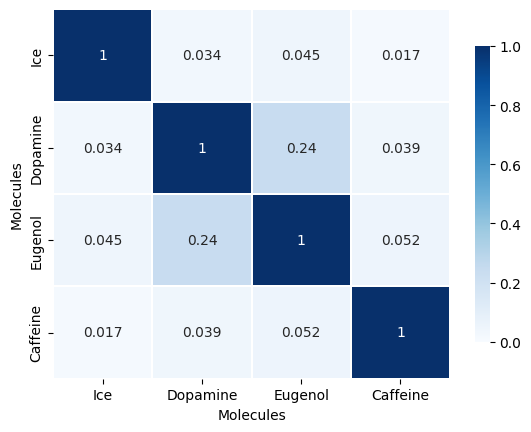

In [ ]:
# heatmap: the color intensity the correlation between x and y

heatmap = sns.heatmap(similarity_matrix, annot=True, cmap="Blues", vmin= 0.0, vmax=1.0,
           linewidth=0.3, cbar_kws={"shrink": .8})


In [ ]:
# Heatmap 2

cm = sns.light_palette("red", as_cmap=True)
s = similarity_matrix.style.background_gradient(cmap=cm)
s

Molecules,Ice,Dopamine,Eugenol,Caffeine
Molecules,,,,
Ice,1.000000,0.033898,0.045455,0.016949
Dopamine,0.033898,1.000000,0.240000,0.039216
Eugenol,0.045455,0.240000,1.000000,0.051724
Caffeine,0.016949,0.039216,0.051724,1.000000


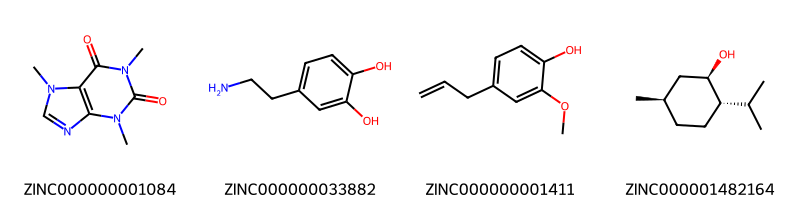

In [ ]:
# Draw the 2D structure of moleules
mol_list = []
for smiles in mdata['smiles']:
  mol = Chem.MolFromSmiles(smiles)
  mol_list.append(mol)

img = Draw.MolsToGridImage(mol_list, molsPerRow= 4, useSVG=True, legends = list(mdata['zinc_id']))
img


,Molecules,molecule,zinc_id,smiles,MolWt,HeavyAtoms_number,Rotatable_bonds,logP
0,Ice,,ZINC000000001084,Cn1c(=O)c2c(ncn2C)n(C)c1=O,194.194,14,0,-1.0293
1,Dopamine,,ZINC000000033882,NCCc1ccc(O)c(O)c1,153.181,11,2,0.5990
2,Eugenol,,ZINC000000001411,C=CCc1ccc(O)c(OC)c1,164.204,12,3,2.1293
3,Caffeine,,ZINC000001482164,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1O,156.269,11,1,2.4395

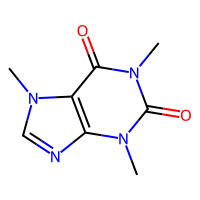
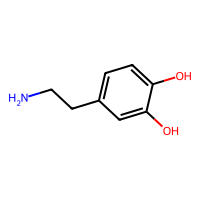
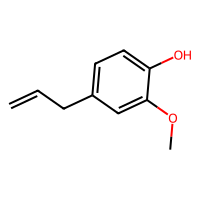
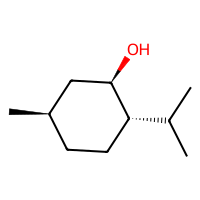

In [ ]:
# SettingWithCopyWarning
pd.options.mode.chained_assignment = None

PandasTools.AddMoleculeColumnToFrame(mdata, 'smiles', 'molecule', includeFingerprints=True)

#2D structures of the molecules are explicitly rendered as images in the DataFrame
PandasTools.RenderImagesInAllDataFrames(images=True)

mdata = mdata[['Molecules', 'molecule', 'zinc_id', 'smiles', 'MolWt', 'HeavyAtoms_number',
               'Rotatable_bonds', 'logP']]

mdata


[11:16:57] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:57] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:57] Molecule does not have explicit Hs. Consider calling AddHs()
[11:16:57] Molecule does not have explicit Hs. Consider calling AddHs()


,Mol,Mol_with_H,conformers
0,,,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
1,,,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
2,,,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
3,,,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"

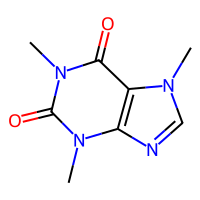
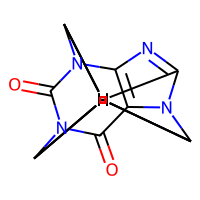
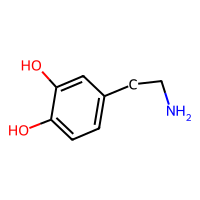
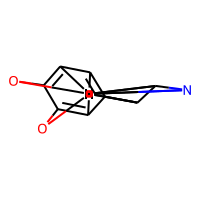
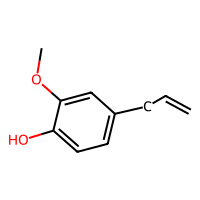
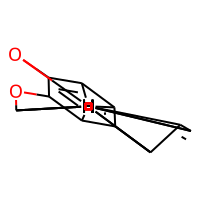
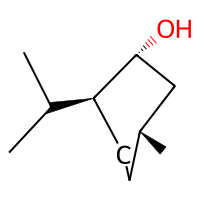
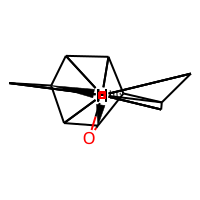

In [ ]:
def get_H(mol):
  if mol:
    MolwithHs = Chem.AddHs(mol)
    return MolwithHs
  else:
    return None

def get_conformers(mol):
  if mol:
    cids = AllChem.EmbedMultipleConfs(mol, numThreads = 0)
    return cids
  else:
    return None



dataframe_3D = pd.DataFrame()
dataframe_3D['Mol'] = mdata['molecule']
dataframe_3D ['Mol_with_H'] = dataframe_3D['Mol'].apply(get_H)
dataframe_3D['conformers'] = dataframe_3D['Mol'].apply(get_conformers)


dataframe_3D

In [ ]:
# Create SDF files for each molecule individually
for mol_index, conformers in enumerate(dataframe_3D['conformers']):
    with Chem.SDWriter(f'conformers{mol_index}.sdf') as file:
        for conf in conformers:
            file.write(dataframe_3D['Mol_with_H'][mol_index], confId=conf)


In [ ]:
# Create SDF files for all molecules together
with Chem.SDWriter('all_conformers.sdf') as file:
    for mol_index, conformers in enumerate(dataframe_3D['conformers']):
        for conf in conformers:
            file.write(dataframe_3D['Mol_with_H'][mol_index], confId=conf)